# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [4]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_h
Gradient check passed!
Checking gradient for B_h
Gradient check passed!
Checking gradient for W_o
Gradient check passed!
Checking gradient for B_o
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_h
Gradient check passed!
Checking gradient for B_h
Gradient check passed!
Checking gradient for W_o
Gradient check passed!
Checking gradient for B_o
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302029, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301851, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302623, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301124, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302831, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301638, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302117, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302807, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302832, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301772, Train acc

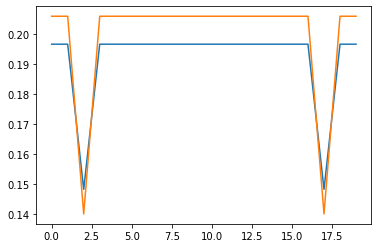

In [11]:
plt.plot(train_history)
plt.plot(val_history)

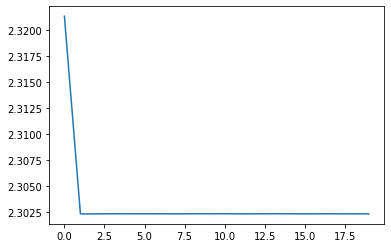

In [12]:
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [13]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217454, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256101, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [14]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308033, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317549, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270323, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308261, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264990, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279901, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256404, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295822, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278750, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [30]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331343, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.320039, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.311452, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.338764, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.330363, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.236329, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.293843, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.276581, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.312819, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.272468, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.936523, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.793725, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.840551, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.241522, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.767172, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.680809, Train acc

Loss: 1.362068, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.096460, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.466967, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.373058, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.409015, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.094818, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.214879, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.575206, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.146781, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.328045, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.412884, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.468863, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406597, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.267244, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.258457, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.540525, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [31]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.339499, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.328257, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.295433, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.259359, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.330018, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.318735, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.291630, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.331060, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.235076, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.345930, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.238900, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.941374, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.611011, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.859424, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.944538, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.003366, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [38]:
%%time
from itertools import product

# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
learning_rate_decays = [0.9, 0.99, 0.999]
hidden_layer_size = 256
num_epochs = 200
batch_size = 128

best_classifier = None
best_val_accuracy = 0.0

loss_history = []
train_history = []
val_history = []

for learning_rate, reg_strength, learning_rate_decay in product(learning_rates, reg_strengths, learning_rate_decays):
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, 
                      dataset, 
                      MomentumSGD(), 
                      learning_rate=learning_rate, 
                      learning_rate_decay=learning_rate_decay, 
                      num_epochs=num_epochs, batch_size=batch_size)
    lh, th, vh = trainer.fit()
    loss_history.append(lh)
    train_history.append(th)
    val_history.append(vh)
    
    pred = model.predict(val_X)
    acc = multiclass_accuracy(pred, val_y)
    if (acc > best_val_accuracy):
        loss_history = lh
        train_history = th
        val_history = 
        best_classifier = model
        best_val_accuracy = acc


print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.284134, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293201, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294818, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315282, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309639, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301463, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272857, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266971, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.322484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.225871, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246725, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272642, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290367, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.241359, Train acc

Loss: 2.356487, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239881, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247069, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285982, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314557, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244722, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.345505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240928, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.232625, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291811, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308772, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290317, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266244, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309589, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244002, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308904, Train acc

Loss: 2.262042, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312905, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296547, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273499, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315351, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249961, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293046, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.384113, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284858, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296813, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272948, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273998, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237021, Train accuracy: 0.181556, val accuracy: 0.191000
Loss: 2.246578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277714, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253989, Train acc

Loss: 2.306792, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.207470, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.238362, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292163, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259774, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267479, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245585, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213722, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257421, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277622, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275766, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228347, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263438, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271859, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291813, Train acc

Loss: 2.269000, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.236063, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253929, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267478, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293522, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299949, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305277, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279571, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336145, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270640, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253708, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254180, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265910, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244714, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280577, Train acc

Loss: 1.531195, Train accuracy: 0.686000, val accuracy: 0.665000
Loss: 1.673498, Train accuracy: 0.682111, val accuracy: 0.665000
Loss: 1.696169, Train accuracy: 0.684111, val accuracy: 0.662000
Loss: 1.795365, Train accuracy: 0.685556, val accuracy: 0.675000
Loss: 1.972259, Train accuracy: 0.687778, val accuracy: 0.676000
Loss: 1.828322, Train accuracy: 0.688444, val accuracy: 0.673000
Loss: 1.804544, Train accuracy: 0.688111, val accuracy: 0.673000
Loss: 1.548936, Train accuracy: 0.688111, val accuracy: 0.677000
Loss: 1.761023, Train accuracy: 0.685889, val accuracy: 0.675000
Loss: 1.893344, Train accuracy: 0.686889, val accuracy: 0.678000
Loss: 1.499327, Train accuracy: 0.686000, val accuracy: 0.679000
Loss: 1.588190, Train accuracy: 0.687000, val accuracy: 0.671000
Loss: 1.764302, Train accuracy: 0.686000, val accuracy: 0.676000
Loss: 1.563349, Train accuracy: 0.688000, val accuracy: 0.676000
Loss: 1.779892, Train accuracy: 0.688556, val accuracy: 0.675000
Loss: 1.692813, Train acc

Loss: 1.929767, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.591538, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.585771, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.815780, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.714930, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.622043, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.688296, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.604883, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.772866, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.739791, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.798512, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.762160, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.954047, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.676103, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.708587, Train accuracy: 0.688333, val accuracy: 0.676000
Loss: 1.808968, Train acc

Loss: 1.681579, Train accuracy: 0.629222, val accuracy: 0.629000
Loss: 1.769734, Train accuracy: 0.642444, val accuracy: 0.632000
Loss: 1.852279, Train accuracy: 0.635333, val accuracy: 0.612000
Loss: 1.891424, Train accuracy: 0.627889, val accuracy: 0.618000
Loss: 1.810837, Train accuracy: 0.644778, val accuracy: 0.639000
Loss: 1.962220, Train accuracy: 0.654111, val accuracy: 0.640000
Loss: 1.635926, Train accuracy: 0.624889, val accuracy: 0.630000
Loss: 1.999127, Train accuracy: 0.641667, val accuracy: 0.641000
Loss: 1.797568, Train accuracy: 0.640444, val accuracy: 0.630000
Loss: 1.614566, Train accuracy: 0.637111, val accuracy: 0.644000
Loss: 1.631616, Train accuracy: 0.641556, val accuracy: 0.622000
Loss: 2.012415, Train accuracy: 0.610222, val accuracy: 0.610000
Loss: 1.945325, Train accuracy: 0.646778, val accuracy: 0.614000
Loss: 1.835552, Train accuracy: 0.648444, val accuracy: 0.637000
Loss: 1.894057, Train accuracy: 0.645778, val accuracy: 0.623000
Loss: 1.674696, Train acc

Loss: 1.886921, Train accuracy: 0.562556, val accuracy: 0.566000
Loss: 1.988366, Train accuracy: 0.523667, val accuracy: 0.526000
Loss: 1.652476, Train accuracy: 0.558444, val accuracy: 0.560000
Loss: 2.079882, Train accuracy: 0.517111, val accuracy: 0.538000
Loss: 2.088709, Train accuracy: 0.538778, val accuracy: 0.523000
Loss: 1.871195, Train accuracy: 0.535333, val accuracy: 0.526000
Loss: 2.064444, Train accuracy: 0.493000, val accuracy: 0.495000
Loss: 1.888687, Train accuracy: 0.522889, val accuracy: 0.514000
Loss: 2.157791, Train accuracy: 0.522333, val accuracy: 0.506000
Loss: 1.922584, Train accuracy: 0.530667, val accuracy: 0.544000
Loss: 2.014183, Train accuracy: 0.550889, val accuracy: 0.558000
Loss: 2.169322, Train accuracy: 0.537111, val accuracy: 0.548000
Loss: 2.003291, Train accuracy: 0.535333, val accuracy: 0.544000
Loss: 1.895414, Train accuracy: 0.525667, val accuracy: 0.533000
Loss: 1.951750, Train accuracy: 0.524444, val accuracy: 0.523000
Loss: 1.830547, Train acc

Loss: 2.239584, Train accuracy: 0.528222, val accuracy: 0.495000
Loss: 2.119129, Train accuracy: 0.550667, val accuracy: 0.547000
Loss: 2.142780, Train accuracy: 0.500000, val accuracy: 0.483000
Loss: 1.940802, Train accuracy: 0.495333, val accuracy: 0.519000
Loss: 1.912044, Train accuracy: 0.539667, val accuracy: 0.560000
Loss: 1.787100, Train accuracy: 0.551556, val accuracy: 0.538000
Loss: 1.825127, Train accuracy: 0.512778, val accuracy: 0.513000
Loss: 1.890592, Train accuracy: 0.582667, val accuracy: 0.587000
Loss: 2.124398, Train accuracy: 0.563778, val accuracy: 0.575000
Loss: 2.000076, Train accuracy: 0.526000, val accuracy: 0.511000
Loss: 2.145183, Train accuracy: 0.542000, val accuracy: 0.532000
Loss: 1.751768, Train accuracy: 0.481444, val accuracy: 0.513000
Loss: 1.950993, Train accuracy: 0.562222, val accuracy: 0.561000
Loss: 1.829815, Train accuracy: 0.540889, val accuracy: 0.528000
Loss: 1.890684, Train accuracy: 0.527333, val accuracy: 0.516000
Loss: 1.897636, Train acc

Loss: 1.055401, Train accuracy: 0.896444, val accuracy: 0.774000
Loss: 0.631206, Train accuracy: 0.896111, val accuracy: 0.775000
Loss: 0.628586, Train accuracy: 0.896333, val accuracy: 0.774000
Loss: 0.767233, Train accuracy: 0.896444, val accuracy: 0.773000
Loss: 0.786821, Train accuracy: 0.896444, val accuracy: 0.775000
Loss: 0.745649, Train accuracy: 0.896444, val accuracy: 0.772000
Loss: 0.815347, Train accuracy: 0.896556, val accuracy: 0.773000
Loss: 0.749421, Train accuracy: 0.896444, val accuracy: 0.773000
Loss: 0.580795, Train accuracy: 0.896667, val accuracy: 0.773000
Loss: 0.670237, Train accuracy: 0.896444, val accuracy: 0.773000
Loss: 0.861023, Train accuracy: 0.896556, val accuracy: 0.772000
Loss: 0.639024, Train accuracy: 0.896556, val accuracy: 0.772000
Loss: 0.630124, Train accuracy: 0.896444, val accuracy: 0.773000
Loss: 0.764398, Train accuracy: 0.896556, val accuracy: 0.773000
Loss: 0.644213, Train accuracy: 0.896444, val accuracy: 0.773000
Loss: 0.745101, Train acc

Loss: 0.723816, Train accuracy: 0.896222, val accuracy: 0.773000
Loss: 0.692163, Train accuracy: 0.896222, val accuracy: 0.773000
Loss: 0.583581, Train accuracy: 0.896222, val accuracy: 0.773000
Loss: 2.080692, Train accuracy: 0.205333, val accuracy: 0.209000
Loss: 1.884481, Train accuracy: 0.425000, val accuracy: 0.441000
Loss: 1.019569, Train accuracy: 0.555000, val accuracy: 0.545000
Loss: 1.229744, Train accuracy: 0.578333, val accuracy: 0.576000
Loss: 1.039801, Train accuracy: 0.667444, val accuracy: 0.628000
Loss: 1.421234, Train accuracy: 0.615333, val accuracy: 0.595000
Loss: 1.472249, Train accuracy: 0.708222, val accuracy: 0.668000
Loss: 1.381483, Train accuracy: 0.730000, val accuracy: 0.700000
Loss: 1.131741, Train accuracy: 0.710889, val accuracy: 0.681000
Loss: 1.131960, Train accuracy: 0.743778, val accuracy: 0.675000
Loss: 1.079367, Train accuracy: 0.695889, val accuracy: 0.647000
Loss: 1.176244, Train accuracy: 0.744556, val accuracy: 0.666000
Loss: 1.450219, Train acc

Loss: 0.671130, Train accuracy: 0.914889, val accuracy: 0.764000
Loss: 0.765970, Train accuracy: 0.922444, val accuracy: 0.777000
Loss: 0.773845, Train accuracy: 0.943000, val accuracy: 0.781000
Loss: 0.777035, Train accuracy: 0.937222, val accuracy: 0.785000
Loss: 0.649331, Train accuracy: 0.909667, val accuracy: 0.756000
Loss: 0.703665, Train accuracy: 0.939667, val accuracy: 0.771000
Loss: 0.689385, Train accuracy: 0.937667, val accuracy: 0.778000
Loss: 0.594261, Train accuracy: 0.938333, val accuracy: 0.790000
Loss: 0.736247, Train accuracy: 0.953222, val accuracy: 0.791000
Loss: 0.844860, Train accuracy: 0.943000, val accuracy: 0.789000
Loss: 0.750506, Train accuracy: 0.943222, val accuracy: 0.778000
Loss: 0.687039, Train accuracy: 0.937444, val accuracy: 0.779000
Loss: 0.717763, Train accuracy: 0.943333, val accuracy: 0.782000
Loss: 0.650777, Train accuracy: 0.936556, val accuracy: 0.778000
Loss: 0.697689, Train accuracy: 0.942556, val accuracy: 0.785000
Loss: 0.613720, Train acc

Loss: 1.312920, Train accuracy: 0.753889, val accuracy: 0.672000
Loss: 1.152037, Train accuracy: 0.794889, val accuracy: 0.708000
Loss: 1.630073, Train accuracy: 0.785111, val accuracy: 0.696000
Loss: 1.285804, Train accuracy: 0.777778, val accuracy: 0.700000
Loss: 0.813712, Train accuracy: 0.752778, val accuracy: 0.671000
Loss: 1.163612, Train accuracy: 0.810556, val accuracy: 0.736000
Loss: 1.305530, Train accuracy: 0.770667, val accuracy: 0.696000
Loss: 0.877280, Train accuracy: 0.779667, val accuracy: 0.702000
Loss: 0.983734, Train accuracy: 0.801778, val accuracy: 0.702000
Loss: 1.209105, Train accuracy: 0.804333, val accuracy: 0.717000
Loss: 0.981414, Train accuracy: 0.809667, val accuracy: 0.706000
Loss: 0.941820, Train accuracy: 0.746333, val accuracy: 0.667000
Loss: 1.281258, Train accuracy: 0.821111, val accuracy: 0.732000
Loss: 1.113377, Train accuracy: 0.754111, val accuracy: 0.683000
Loss: 1.361220, Train accuracy: 0.834556, val accuracy: 0.735000
Loss: 1.140444, Train acc

Loss: 1.115688, Train accuracy: 0.819000, val accuracy: 0.712000
Loss: 1.153230, Train accuracy: 0.755333, val accuracy: 0.653000
Loss: 1.237866, Train accuracy: 0.783556, val accuracy: 0.692000
Loss: 0.914772, Train accuracy: 0.820444, val accuracy: 0.709000
Loss: 1.073881, Train accuracy: 0.813000, val accuracy: 0.722000
Loss: 0.951427, Train accuracy: 0.822000, val accuracy: 0.717000
Loss: 1.014765, Train accuracy: 0.801667, val accuracy: 0.702000
Loss: 0.747238, Train accuracy: 0.837333, val accuracy: 0.733000
Loss: 0.948611, Train accuracy: 0.829000, val accuracy: 0.731000
Loss: 1.116893, Train accuracy: 0.797111, val accuracy: 0.695000
Loss: 0.954857, Train accuracy: 0.836444, val accuracy: 0.726000
Loss: 0.955677, Train accuracy: 0.803667, val accuracy: 0.717000
Loss: 1.190877, Train accuracy: 0.805333, val accuracy: 0.724000
Loss: 1.178632, Train accuracy: 0.804667, val accuracy: 0.698000
Loss: 0.947244, Train accuracy: 0.824889, val accuracy: 0.722000
Loss: 1.280003, Train acc

Loss: 0.354078, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.217079, Train accuracy: 0.928778, val accuracy: 0.762000
Loss: 0.344254, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.295899, Train accuracy: 0.928667, val accuracy: 0.762000
Loss: 0.372156, Train accuracy: 0.928667, val accuracy: 0.762000
Loss: 0.626005, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.437204, Train accuracy: 0.928778, val accuracy: 0.762000
Loss: 0.379417, Train accuracy: 0.928778, val accuracy: 0.762000
Loss: 0.374060, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.252538, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.305019, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.423056, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.402733, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.355529, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.501606, Train accuracy: 0.928778, val accuracy: 0.761000
Loss: 0.292335, Train acc

Loss: 0.496819, Train accuracy: 0.881889, val accuracy: 0.710000
Loss: 0.422221, Train accuracy: 0.911778, val accuracy: 0.736000
Loss: 0.511421, Train accuracy: 0.928333, val accuracy: 0.764000
Loss: 0.369660, Train accuracy: 0.942778, val accuracy: 0.766000
Loss: 0.303753, Train accuracy: 0.945000, val accuracy: 0.755000
Loss: 0.295910, Train accuracy: 0.933111, val accuracy: 0.755000
Loss: 0.270315, Train accuracy: 0.928111, val accuracy: 0.744000
Loss: 0.633551, Train accuracy: 0.920889, val accuracy: 0.734000
Loss: 0.268891, Train accuracy: 0.941556, val accuracy: 0.746000
Loss: 0.266990, Train accuracy: 0.940778, val accuracy: 0.758000
Loss: 0.420178, Train accuracy: 0.955222, val accuracy: 0.746000
Loss: 0.295011, Train accuracy: 0.944667, val accuracy: 0.741000
Loss: 0.321522, Train accuracy: 0.946778, val accuracy: 0.757000
Loss: 0.251243, Train accuracy: 0.950111, val accuracy: 0.763000
Loss: 0.262521, Train accuracy: 0.952889, val accuracy: 0.749000
Loss: 0.289991, Train acc

Loss: 0.137951, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.141429, Train accuracy: 1.000000, val accuracy: 0.770000
Loss: 0.154370, Train accuracy: 1.000000, val accuracy: 0.768000
Loss: 0.136861, Train accuracy: 1.000000, val accuracy: 0.771000
Loss: 0.140951, Train accuracy: 1.000000, val accuracy: 0.775000
Loss: 0.144918, Train accuracy: 0.999889, val accuracy: 0.772000
Loss: 0.150006, Train accuracy: 1.000000, val accuracy: 0.774000
Loss: 0.138272, Train accuracy: 1.000000, val accuracy: 0.774000
Loss: 0.157281, Train accuracy: 1.000000, val accuracy: 0.775000
Loss: 0.147218, Train accuracy: 1.000000, val accuracy: 0.773000
Loss: 0.140182, Train accuracy: 1.000000, val accuracy: 0.773000
Loss: 0.138342, Train accuracy: 1.000000, val accuracy: 0.772000
Loss: 0.162613, Train accuracy: 1.000000, val accuracy: 0.771000
Loss: 0.144269, Train accuracy: 1.000000, val accuracy: 0.773000
Loss: 0.142681, Train accuracy: 1.000000, val accuracy: 0.781000
Loss: 0.145909, Train acc

Loss: 0.307572, Train accuracy: 0.960778, val accuracy: 0.756000
Loss: 0.335693, Train accuracy: 0.971778, val accuracy: 0.759000
Loss: 0.483375, Train accuracy: 0.974000, val accuracy: 0.755000
Loss: 0.413738, Train accuracy: 0.958667, val accuracy: 0.745000
Loss: 0.388082, Train accuracy: 0.967000, val accuracy: 0.745000
Loss: 0.295310, Train accuracy: 0.931222, val accuracy: 0.721000
Loss: 0.635828, Train accuracy: 0.972333, val accuracy: 0.767000
Loss: 0.454262, Train accuracy: 0.932333, val accuracy: 0.723000
Loss: 0.323774, Train accuracy: 0.943222, val accuracy: 0.734000
Loss: 0.437835, Train accuracy: 0.940667, val accuracy: 0.725000
Loss: 0.338574, Train accuracy: 0.957333, val accuracy: 0.740000
Loss: 0.331075, Train accuracy: 0.960778, val accuracy: 0.757000
Loss: 0.430248, Train accuracy: 0.944667, val accuracy: 0.726000
Loss: 0.397822, Train accuracy: 0.953556, val accuracy: 0.748000
Loss: 0.357476, Train accuracy: 0.946333, val accuracy: 0.734000
Loss: 0.316303, Train acc

Loss: 0.606797, Train accuracy: 0.856444, val accuracy: 0.742000
Loss: 0.474254, Train accuracy: 0.862778, val accuracy: 0.747000
Loss: 0.407416, Train accuracy: 0.877000, val accuracy: 0.756000
Loss: 0.419090, Train accuracy: 0.880667, val accuracy: 0.751000
Loss: 0.366749, Train accuracy: 0.880889, val accuracy: 0.758000
Loss: 0.471878, Train accuracy: 0.895000, val accuracy: 0.753000
Loss: 0.381386, Train accuracy: 0.902889, val accuracy: 0.760000
Loss: 0.201893, Train accuracy: 0.895556, val accuracy: 0.754000
Loss: 0.622942, Train accuracy: 0.908889, val accuracy: 0.757000
Loss: 0.342799, Train accuracy: 0.908444, val accuracy: 0.764000
Loss: 0.144447, Train accuracy: 0.916444, val accuracy: 0.767000
Loss: 0.257015, Train accuracy: 0.922111, val accuracy: 0.773000
Loss: 0.335703, Train accuracy: 0.919444, val accuracy: 0.766000
Loss: 0.212213, Train accuracy: 0.922444, val accuracy: 0.763000
Loss: 0.304474, Train accuracy: 0.927333, val accuracy: 0.764000
Loss: 0.324513, Train acc

Loss: 0.152054, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.285364, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.178591, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.333348, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.157322, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.246085, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.201633, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.228523, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.199270, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.256442, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.260547, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.318306, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.378692, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.285699, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.274869, Train accuracy: 0.940778, val accuracy: 0.766000
Loss: 0.183007, Train acc

Loss: 0.041317, Train accuracy: 0.999333, val accuracy: 0.772000
Loss: 0.048250, Train accuracy: 0.999000, val accuracy: 0.773000
Loss: 0.035637, Train accuracy: 0.999000, val accuracy: 0.766000
Loss: 0.047647, Train accuracy: 0.999778, val accuracy: 0.771000
Loss: 0.045053, Train accuracy: 0.999667, val accuracy: 0.779000
Loss: 0.032497, Train accuracy: 0.999889, val accuracy: 0.777000
Loss: 0.038875, Train accuracy: 0.999889, val accuracy: 0.775000
Loss: 0.029351, Train accuracy: 0.999889, val accuracy: 0.778000
Loss: 0.038559, Train accuracy: 1.000000, val accuracy: 0.775000
Loss: 0.036920, Train accuracy: 0.999889, val accuracy: 0.773000
Loss: 0.034986, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.033901, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.038637, Train accuracy: 1.000000, val accuracy: 0.773000
Loss: 0.031880, Train accuracy: 1.000000, val accuracy: 0.778000
Loss: 0.038083, Train accuracy: 1.000000, val accuracy: 0.775000
Loss: 0.040305, Train acc

Loss: 0.028909, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.031985, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.033329, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.030205, Train accuracy: 1.000000, val accuracy: 0.777000
Loss: 0.031457, Train accuracy: 1.000000, val accuracy: 0.778000
Loss: 0.029235, Train accuracy: 1.000000, val accuracy: 0.776000
Loss: 2.125501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.659164, Train accuracy: 0.459333, val accuracy: 0.478000
Loss: 1.099663, Train accuracy: 0.563889, val accuracy: 0.557000
Loss: 1.420360, Train accuracy: 0.659444, val accuracy: 0.634000
Loss: 1.218282, Train accuracy: 0.668667, val accuracy: 0.641000
Loss: 0.989881, Train accuracy: 0.686667, val accuracy: 0.656000
Loss: 0.735775, Train accuracy: 0.734667, val accuracy: 0.677000
Loss: 0.618134, Train accuracy: 0.752333, val accuracy: 0.688000
Loss: 0.900512, Train accuracy: 0.700667, val accuracy: 0.641000
Loss: 1.154060, Train acc

Loss: 0.065973, Train accuracy: 0.995778, val accuracy: 0.770000
Loss: 0.155010, Train accuracy: 0.997000, val accuracy: 0.766000
Loss: 0.091804, Train accuracy: 0.995111, val accuracy: 0.772000
Loss: 0.071547, Train accuracy: 0.997222, val accuracy: 0.773000
Loss: 0.087537, Train accuracy: 0.999667, val accuracy: 0.770000
Loss: 0.097150, Train accuracy: 0.995778, val accuracy: 0.758000
Loss: 0.090067, Train accuracy: 0.993889, val accuracy: 0.759000
Loss: 0.250014, Train accuracy: 0.985667, val accuracy: 0.761000
Loss: 0.085800, Train accuracy: 0.989333, val accuracy: 0.768000
Loss: 0.070132, Train accuracy: 0.997444, val accuracy: 0.777000
Loss: 0.060902, Train accuracy: 0.996000, val accuracy: 0.765000
Loss: 0.062766, Train accuracy: 0.997000, val accuracy: 0.776000
Loss: 0.061696, Train accuracy: 0.998556, val accuracy: 0.767000
Loss: 0.058801, Train accuracy: 0.998111, val accuracy: 0.775000
Loss: 0.058471, Train accuracy: 1.000000, val accuracy: 0.773000
Loss: 0.060227, Train acc

Loss: 2.245438, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272403, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297149, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278490, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262157, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278109, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231329, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301682, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274417, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289175, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251409, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209097, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289336, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248900, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305485, Train accuracy: 0.196667, val accuracy: 0.206000


KeyboardInterrupt: 

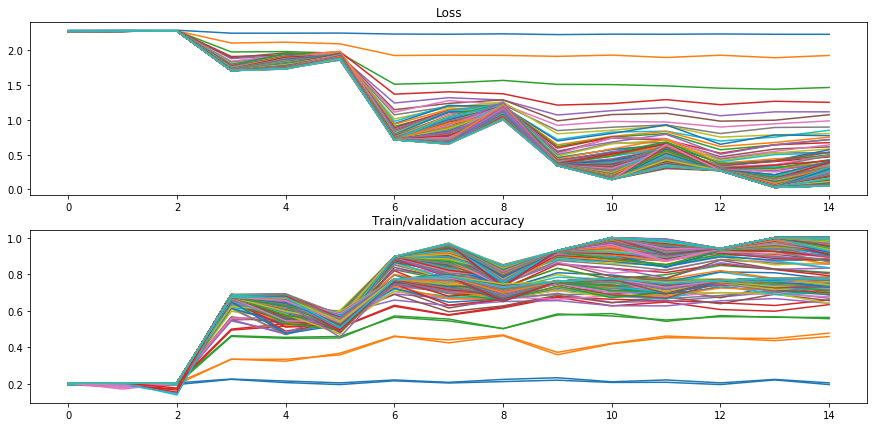

In [39]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [40]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.775000
